In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
example = "Quadratic"

In [3]:
#############################################################################
# Exact solution 
#############################################################################

def exactSolution(x):
    
    if example == "Cubic":
        return (2/3/np.sqrt(3)) * ( 9*x - 9*x*x + 2 * x * x * x )
    elif example == "Quartic":
        return 16/9 * x * x - 32/27 * x * x * x + 16/81 * x * x * x * x
    elif example == "Quadratic":
        return  4/3 * x - 4/9 * x * x
    else:
        print("Error: Either provide Linear, Quadratic, Quartic, or Cubic")
        sys.exit()

In [4]:
#############################################################################
# Solve the system
#############################################################################

def solve(M,f):
    return np.linalg.solve(M,f)

In [5]:
#############################################################################
# Loading
#############################################################################

def f(x):
    
    if example == "Cubic":
        return -( 2/np.sqrt(3)) * ( -6 + 4*x )
    elif example == "Quartic":
        return  -32/9 + 64/9 * x - 64/27 * x * x
    elif example == "Quadratic":
        return 8/9
    else:
        print("Error: Either provide Quadratic, Quartic, or Cubic")
        sys.exit()

def forceFull(n,x):
    
    force = np.zeros(n)
   
    for i in range(1,n-1):
        force[i] = f(x[i])
    
    force[n-1] = 0
    
    return force

def forceCoupling(n,x):
    
    dim = 2*n + 2*n-1
    
    force = np.zeros(dim)
   
    for i in range(1,dim-1):
        force[i] = f(x[i])
    
    force[dim-1] = 0
    
    return force

In [6]:
#############################################################################
# Assemble the stiffness matrix for the finite difference model (FD)
#############################################################################

def FDM(n,h):

    M = np.zeros([n,n])

    M[0][0] = 1

    for i in range(1,n-1):
        M[i][i-1] = -2
        M[i][i] = 4
        M[i][i+1] = -2

    M[n-1][n-1] = 1

    M *= 1./(2.*h*h)

    return M

In [7]:
#############################################################################
# Assemble the stiffness matrix for the coupling of FDM - VHM - FDM
#############################################################################

def CouplingFDVHM(n,h):

    fVHM = 1./(8.*h/2*h/2)
    fFDM = 1./(2.*h*h)
    
    dim = 2*n + 2*n-1
    

    M = np.zeros([dim,dim])
    
    M[0][0] = 1 

    for i in range(1,n-1):
        M[i][i-1] = -2 * fFDM
        M[i][i] = 4 * fFDM
        M[i][i+1] = -2 * fFDM

    M[n-1][n-1] = -1 
    M[n-1][n] = 1  

    M[n][n-1] = 11*h * fFDM / 3
    M[n][n-2] = -18*h * fFDM / 3
    M[n][n-3] = 9*h * fFDM / 3
    M[n][n-4] = -2*h * fFDM / 3

    M[n][n] = 11 / 6 / h *2
    M[n][n+1] = -18 / 6 / h *2
    M[n][n+2] = 9 / 6 / h *2
    M[n][n+3] = -2 / 6 / h *2

    M[n+1][n] = -8 * fVHM
    M[n+1][n+1] = 16 * fVHM
    M[n+1][n+2] = -8 * fVHM
    
    mid = n+2*n -2

    for i in range(n+2,mid-1):
        M[i][i-2] = -1. * fVHM
        M[i][i-1] = -4. * fVHM
        M[i][i] = 10. * fVHM
        M[i][i+1] =  -4. * fVHM
        M[i][i+2] = -1. * fVHM
        
   
        
    M[mid-1][mid-2] = -8 * fVHM
    M[mid-1][mid-1] = 16 * fVHM
    M[mid-1][mid] = -8 * fVHM

    M[mid][mid+1] = -1 
    M[mid][mid] = 1  

    M[mid+1][mid+1-1] = 11 / 6 / h *2
    M[mid+1][mid+1-2] = -18 / 6 / h*2
    M[mid+1][mid+1-3] = 9 / 6 / h*2
    M[mid+1][mid+1-4] = -2 / 6 / h*2

    M[mid+1][mid+1] = 11 *h * fFDM / 3
    M[mid+1][mid+1+1] = -18 *h * fFDM / 3
    M[mid+1][mid+1+2] = 9 *h * fFDM / 3
    M[mid+1][mid+1+3] = -2 *h * fFDM / 3

    for i in range(mid+2,dim-1):
        M[i][i-1] = -2 * fFDM
        M[i][i] = 4 * fFDM
        M[i][i+1] = -2 * fFDM

    M[dim-1][dim-1] = 1
    
    #np.savetxt("matrix2.csv", M, delimiter=",")

    return M

In [8]:
def compute(i):
    
    n = np.power(2,int(i))
    h = 1./n
    nodes = n + 1
    
    print(nodes,h)
    x1 = np.linspace(0,1,nodes)
    x2 = np.linspace(1,2.,2*nodes-1)
    x3 = np.linspace(2,3.,nodes)
    x = np.array(np.concatenate((x1,x2,x3)))
    
    M = CouplingFDVHM(nodes,h)
    
    f = forceCoupling(nodes,x)
    
    f[n] = 0
    f[n+1] = 0
    
    mid = n+2*n+1

    f[mid] = 0
    f[mid+1] = 0
    
    u = solve(M,f)
    
    x1 = x[0:nodes]
    x2 = x[nodes+1:mid+1]
    x3 = x[mid+2:len(x)]
    
    u1 = u[0:nodes]
    u2 = u[nodes+1:mid+1]
    u3 = u[mid+2:len(x)]
    
    x = np.concatenate([x1,x2,x3])
    u = np.concatenate([u1,u2,u3])
    
    plt.plot(x,u,label="$hFD=$"+str(h))
    plt.grid(True)
    
    x = np.arange(0,3+h/2,h/2)
    interval = int(len(x)/3)
    
    forceFD = forceFull(len(x),x)
    MFD = FDM(len(x),h/2)
    
    uFM = solve(MFD,forceFD)
    
    print(len(uFM),len(x))
    
    x1 = x[0:interval:2]
    x2 = x[interval:2*interval]
    x3 = x[2*interval:len(x):2]
    x = np.concatenate([x1,x2,x3])
    
    uFD1 = uFM[0:interval:2]
    uFD2 = uFM[interval:2*interval]
    uFD3 = uFM[2*interval:len(uFM):2]
    uFD = np.concatenate([uFD1,uFD2,uFD3])
    
    print(len(uFD),len(x))
    print(x)
    
    return u , uFD , x

5 0.25
25 25
17 17
[0.    0.25  0.5   0.75  1.    1.125 1.25  1.375 1.5   1.625 1.75  1.875
 2.    2.25  2.5   2.75  3.   ]
9 0.125
49 49
33 33
[0.     0.125  0.25   0.375  0.5    0.625  0.75   0.875  1.     1.0625
 1.125  1.1875 1.25   1.3125 1.375  1.4375 1.5    1.5625 1.625  1.6875
 1.75   1.8125 1.875  1.9375 2.     2.125  2.25   2.375  2.5    2.625
 2.75   2.875  3.    ]
17 0.0625
97 97
65 65
[0.      0.0625  0.125   0.1875  0.25    0.3125  0.375   0.4375  0.5
 0.5625  0.625   0.6875  0.75    0.8125  0.875   0.9375  1.      1.03125
 1.0625  1.09375 1.125   1.15625 1.1875  1.21875 1.25    1.28125 1.3125
 1.34375 1.375   1.40625 1.4375  1.46875 1.5     1.53125 1.5625  1.59375
 1.625   1.65625 1.6875  1.71875 1.75    1.78125 1.8125  1.84375 1.875
 1.90625 1.9375  1.96875 2.      2.0625  2.125   2.1875  2.25    2.3125
 2.375   2.4375  2.5     2.5625  2.625   2.6875  2.75    2.8125  2.875
 2.9375  3.     ]


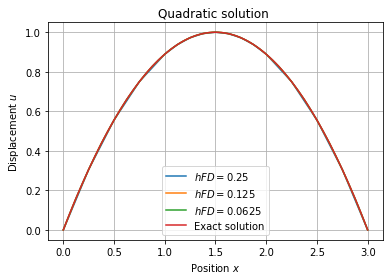

In [9]:
uCoupled = []
uLocal = []
xLocal = []
max_iteration = 5

for i in range(2,max_iteration):
    u , uFD , x = compute(i)
    uCoupled.append(u)
    uLocal.append(uFD)
    xLocal.append(x)

n = np.power(2,int(max_iteration))
h = 1./n

x = np.arange(0,3+h,h)
plt.plot(x,exactSolution(x),label="Exact solution")
plt.legend()
plt.xlabel(r"Position $x$")
plt.ylabel(r"Displacement $u$")
plt.title(r"Quadratic solution ")
plt.savefig("coupling-vhm-"+str(example)+"-dirchelt.pdf")

In [ ]:
plt.clf()

for i in range(0,len(xLocal)):
    #print(xLocal[i])
    #print(uLocal[i])
    plt.plot(xLocal[i],uLocal[i]-uCoupled[i])
    
plt.xlabel(r"Position $x$")
plt.ylabel(r"Displacement $u$")
plt.title(r"Error")
plt.savefig("coupling-vhm-"+str(example)+"-dirchelt-error.pdf")